In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
raster_path = "F:/Springer/Random Forest Model/Data/Sentinel2_Dhaka20.tif"

with rasterio.open(raster_path) as src:
    print("=== Raster Details ===")
    
    print("Driver:", src.driver)
    print("Width:", src.width)
    print("Height:", src.height)
    print("Number of Bands:", src.count)
    print("Data Type:", src.dtypes)
    print("CRS (Coordinate Reference System):", src.crs)
    print("Transform (Affine):", src.transform)
    print("Bounds:", src.bounds)
    print("Resolution (pixel size):", src.res)
    print("NoData Value:", src.nodata)
    print("File Name:", src.name)
    
    for i in range(1, src.count + 1):
        desc = src.descriptions[i - 1]
        print(f"Band {i} Description: {desc}")

=== Raster Details ===
Driver: GTiff
Width: 2038
Height: 2594
Number of Bands: 26
Data Type: ('float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64')
CRS (Coordinate Reference System): EPSG:4326
Transform (Affine): | 0.00, 0.00, 90.33|
| 0.00,-0.00, 23.90|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=90.32973406852483, bottom=23.668092453753857, right=90.51281072342839, top=23.90111543845446)
Resolution (pixel size): (8.983152841195215e-05, 8.983152841195215e-05)
NoData Value: None
File Name: F:/Springer/Random Forest Model/Data/Sentinel2_Dhaka20.tif
Band 1 Description: B1
Band 2 Description: B2
Band 3 Description: B3
Band 4 Description: B4
Band 5 Description: B5
Band 6 Description: B6
Band 7 Description: B7
Band 8 Description: B8
Band 9 Description: B8A
Band 

D:\Mini_A_Sabbir\envs\geo\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


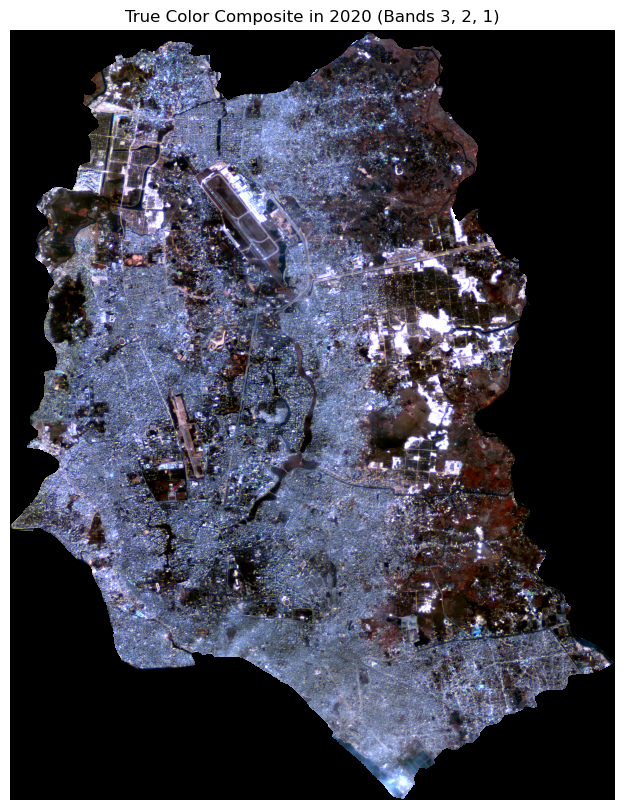

In [5]:
raster_path = "F:/Springer/Random Forest Model/Data/Sentinel2_Dhaka20.tif"

with rasterio.open(raster_path) as src:
    red = src.read(3).astype(np.float32)
    green = src.read(2).astype(np.float32)
    blue = src.read(1).astype(np.float32)
    nodata = src.nodata

rgb = np.stack([red, green, blue], axis=-1)

if nodata is not None:
    mask = (red == nodata) | (green == nodata) | (blue == nodata)
    rgb[mask] = np.nan

def normalize(img):
    img_min, img_max = np.nanpercentile(img, 2), np.nanpercentile(img, 98)
    return np.clip((img - img_min) / (img_max - img_min), 0, 1)

rgb_norm = np.zeros_like(rgb)
for i in range(3):
    rgb_norm[..., i] = normalize(rgb[..., i])

plt.figure(figsize=(10, 10))
plt.imshow(rgb_norm)
plt.title("True Color Composite in 2020 (Bands 3, 2, 1)")
plt.axis("off")

# Save the figure to a file
save_path = "F:/Springer/Random Forest Model/Data/true_color_composite.png"  # Specify your desired file path and name
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [4]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# --------------------------
# Paths
# --------------------------
input_path = "F:/Springer/Random Forest Model/Data/Sentinel2_Dhaka20.tif"
output_path = "F:/Springer/Random Forest Model/Data/S2_SR_HARMONIZED_BANDS_INDICES_2020.tif"
plot_dir = "F:/Springer/Random Forest Model/Data/Index_Plots_2020"
os.makedirs(plot_dir, exist_ok=True)

# --------------------------
# Read and scale input bands
# --------------------------
SCALE_FACTOR = 0.0001  # 0–10000 → 0–1.0

with rasterio.open(input_path) as src:
    profile = src.profile.copy()
    # Read only the bands we need: B2, B3, B4, B8, B11, B12 (index starts at 1)
    B2 = src.read(2).astype(np.float32) * SCALE_FACTOR
    B3 = src.read(3).astype(np.float32) * SCALE_FACTOR
    B4 = src.read(4).astype(np.float32) * SCALE_FACTOR
    B8 = src.read(8).astype(np.float32) * SCALE_FACTOR
    B11 = src.read(11).astype(np.float32) * SCALE_FACTOR
    B12 = src.read(12).astype(np.float32) * SCALE_FACTOR

# --------------------------
# Create mask (optional: check for 0s or nans)
# --------------------------
mask = np.zeros_like(B2, dtype=bool)
for band in [B2, B3, B4, B8, B11, B12]:
    mask |= np.isnan(band) | (band == 0)

print("✅ Masked pixels:", np.sum(mask), "/", mask.size)

# --------------------------
# Safe division function
# --------------------------
def safe_div(a, b):
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.full_like(a, np.nan, dtype=np.float32)
        valid = (b != 0) & ~np.isnan(a) & ~np.isnan(b)
        result[valid] = a[valid] / b[valid]
    return result

# --------------------------
# Compute indices
# --------------------------
NDVI  = safe_div(B8 - B4, B8 + B4)
MNDWI = safe_div(B3 - B11, B3 + B11)
NDBI  = safe_div(B11 - B8, B11 + B8)

# Print ranges
for name, index in zip(['NDVI', 'MNDWI', 'NDBI'], [NDVI, MNDWI, NDBI]):
    print(f"{name} range: min={np.nanmin(index):.4f}, max={np.nanmax(index):.4f}")

# --------------------------
# Apply mask to indices
# --------------------------
for index in [NDVI, MNDWI, NDBI]:
    index[mask] = np.nan

# --------------------------
# Prepare output bands
# --------------------------
nan_value = -1.0  # safer than -9999
all_bands = [B2, B3, B4, B8, B11, B12, NDVI, MNDWI, NDBI]
all_bands = [np.where(np.isnan(band), nan_value, band) for band in all_bands]

# --------------------------
# Update profile
# --------------------------
profile.update(
    count=len(all_bands),
    dtype='float32',
    nodata=nan_value,
    compress='deflate'
)

# --------------------------
# Band names
# --------------------------
orig_names = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
index_names = ['NDVI', 'MNDWI', 'NDBI']
band_names = orig_names + index_names

# --------------------------
# Write output GeoTIFF
# --------------------------
with rasterio.open(output_path, 'w', **profile) as dst:
    for i, band in enumerate(all_bands):
        dst.write(band, i + 1)
        dst.set_band_description(i + 1, band_names[i])

print(f"✅ GeoTIFF written to:\n{output_path}")

# --------------------------
# Plot indices
# --------------------------
for name, index in zip(index_names, [NDVI, MNDWI, NDBI]):
    vmin = np.nanpercentile(index, 2)
    vmax = np.nanpercentile(index, 98)

    plt.figure(figsize=(8, 6))
    plt.imshow(np.where(mask, np.nan, index), cmap='RdYlGn', vmin=vmin, vmax=vmax)
    plt.colorbar(label=name)
    plt.title(f"{name}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f"{name}.png"), dpi=150)
    plt.close()

print(f"✅ Index plots saved to:\n{plot_dir}")


✅ Masked pixels: 1980123 / 5286572
NDVI range: min=-0.3610, max=0.8467
MNDWI range: min=-0.8185, max=0.7939
NDBI range: min=-0.7871, max=0.6390
✅ GeoTIFF written to:
F:/Springer/Random Forest Model/Data/S2_SR_HARMONIZED_BANDS_INDICES_2020.tif
✅ Index plots saved to:
F:/Springer/Random Forest Model/Data/Index_Plots_2020


✅ Raster reprojected and saved to:
F:/Random Forest Model 2020/Reproject\S2_SR_HARMONIZED_BANDS_INDICES_4326.tif
📌 Raster CRS: EPSG:4326
📍 Vegetation original CRS: EPSG:4326
✅ Vegetation shapefile saved to:
F:/Random Forest Model 2020/Reproject\Vegetation_EPSG4326.shp
📍 Builtup original CRS: EPSG:4326
✅ Builtup shapefile saved to:
F:/Random Forest Model 2020/Reproject\Builtup_EPSG4326.shp
📍 Bareland original CRS: EPSG:4326
✅ Bareland shapefile saved to:
F:/Random Forest Model 2020/Reproject\Bareland_EPSG4326.shp
📍 Waterbody original CRS: EPSG:4326
✅ Waterbody shapefile saved to:
F:/Random Forest Model 2020/Reproject\Waterbody_EPSG4326.shp


C:\Users\SABBIR SHAH\AppData\Local\Temp\ipykernel_28364\1309088735.py:82: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', fontsize=9)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


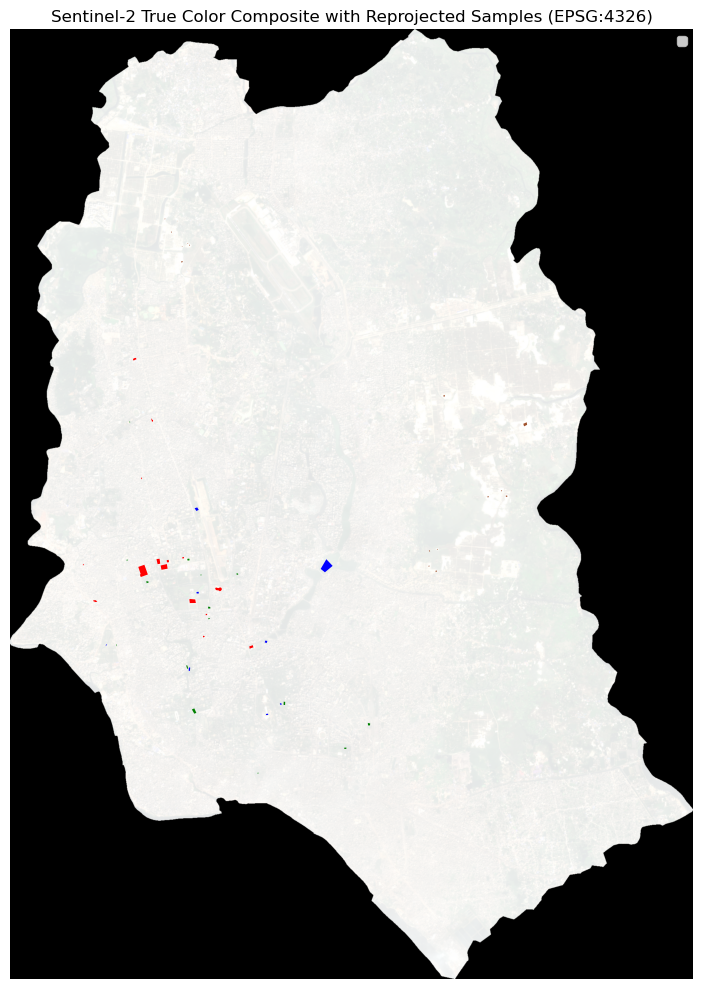

In [3]:
image_path = r"F:/Springer/Random Forest Model/Data/S2_SR_HARMONIZED_BANDS_INDICES_2020.tif"
sample_paths = {
    "Vegetation": r"F:/Springer/Random Forest Model/Data 2020/Vegetation/Vegetation.shp",
    "Builtup": r"F:/Springer/Random Forest Model/Data 2020/Buit-up/Built-up.shp",
    "Bareland": r"F:/Springer/Random Forest Model/Data 2020/Bareland/Bareland.shp",
    "Waterbody": r"F:/Springer/Random Forest Model/Data 2020/Water-body/Water-body.shp",
}

output_dir = r"F:/Random Forest Model 2020/Reproject"
os.makedirs(output_dir, exist_ok=True)

reprojected_image_path = os.path.join(output_dir, "S2_SR_HARMONIZED_BANDS_INDICES_4326.tif")
target_crs = "EPSG:4326"

if not os.path.exists(reprojected_image_path):
    with rasterio.open(image_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(reprojected_image_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest)

    print(f"✅ Raster reprojected and saved to:\n{reprojected_image_path}")

with rasterio.open(reprojected_image_path) as src:
    raster_crs = src.crs
    print("📌 Raster CRS:", raster_crs)

    red = src.read(3)
    green = src.read(2)
    blue = src.read(1)
    rgb = np.stack([red, green, blue], axis=0)

    rgb_min, rgb_max = np.percentile(rgb, (2, 98))
    rgb = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)
    rgb_image = rgb.transpose(1, 2, 0)

    fig, ax = plt.subplots(figsize=(12, 10))
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    ax.imshow(rgb_image, extent=extent)
    ax.set_title("Sentinel-2 True Color Composite with Reprojected Samples (EPSG:4326)")
    ax.axis('off')

reprojected_gdfs = {}
for name, path in sample_paths.items():
    gdf = gpd.read_file(path)
    print(f"📍 {name} original CRS: {gdf.crs}")
    if gdf.crs != target_crs:
        gdf = gdf.to_crs(target_crs)
        print(f"🔄 {name} reprojected to EPSG:4326")

    output_shapefile = os.path.join(output_dir, f"{name}_EPSG4326.shp")
    gdf.to_file(output_shapefile)
    print(f"✅ {name} shapefile saved to:\n{output_shapefile}")
    reprojected_gdfs[name] = gdf

color_map = {
    "Vegetation": "green",
    "Builtup": "red",
    "Bareland": "sienna",
    "Waterbody": "blue",
}

for name, gdf in reprojected_gdfs.items():
    gdf.plot(ax=ax, marker='o', color=color_map[name], markersize=5, label=name)

plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.show()

In [4]:
import os
import pandas as pd
import geopandas as gpd
import rasterio

# Paths
image_path = r"F:/Random Forest Model 2020/Reproject/S2_SR_HARMONIZED_BANDS_INDICES_4326.tif"
sample_dir = r"F:/Random Forest Model 2020/Reproject" 
output_dir = r"F:/Random Forest Model 2020/Training_CSV"
os.makedirs(output_dir, exist_ok=True)

# Sample classes and their associated labels
samples = {
    "Vegetation_EPSG4326.shp": ("Tree", 1),
    "Builtup_EPSG4326.shp": ("Builtup", 2),
    "Bareland_EPSG4326.shp": ("Bareland", 3),
    "Waterbody_EPSG4326.shp": ("Waterbody", 4),
}

with rasterio.open(image_path) as src:
    band_names = [f"Band_{i+1}" for i in range(src.count)]

    for file, (class_name, class_value) in samples.items():
        sample_path = os.path.join(sample_dir, file)
        gdf = gpd.read_file(sample_path)

        # Extract the centroid coordinates for each polygon
        coords = [(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry]

        # Sample the raster values at the centroid coordinates
        values = list(src.sample(coords))

        # Create DataFrame from the raster values and add the class information
        df = pd.DataFrame(values, columns=band_names)
        df["Class"] = class_name
        df["Class_Value"] = class_value
        df["Longitude"] = [coord[0] for coord in coords]  # Longitude from centroids
        df["Latitude"] = [coord[1] for coord in coords]   # Latitude from centroids
        
        # Save the DataFrame to a CSV
        out_csv = os.path.join(output_dir, f"{class_name}.csv")
        df.to_csv(out_csv, index=False)
        print(f"✅ Saved: {out_csv}")


✅ Saved: F:/Random Forest Model 2020/Training_CSV\Tree.csv
✅ Saved: F:/Random Forest Model 2020/Training_CSV\Builtup.csv
✅ Saved: F:/Random Forest Model 2020/Training_CSV\Bareland.csv
✅ Saved: F:/Random Forest Model 2020/Training_CSV\Waterbody.csv


✅ Epoch 1: Best model updated with accuracy: 0.9091
✅ Epoch 2: Best model updated with accuracy: 1.0000

🎯 Best Accuracy Achieved: 1.0
📊 Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



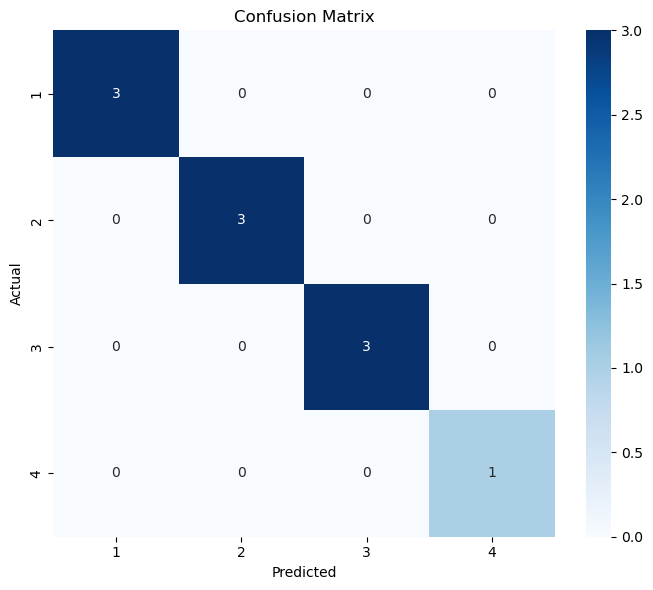

D:\Mini_A_Sabbir\envs\geo\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


✅ Final classified image saved to: F:/Random Forest Model 2020/Classified_Output\Sentinel2_With_Indices_20240217_Classified_float32.tif


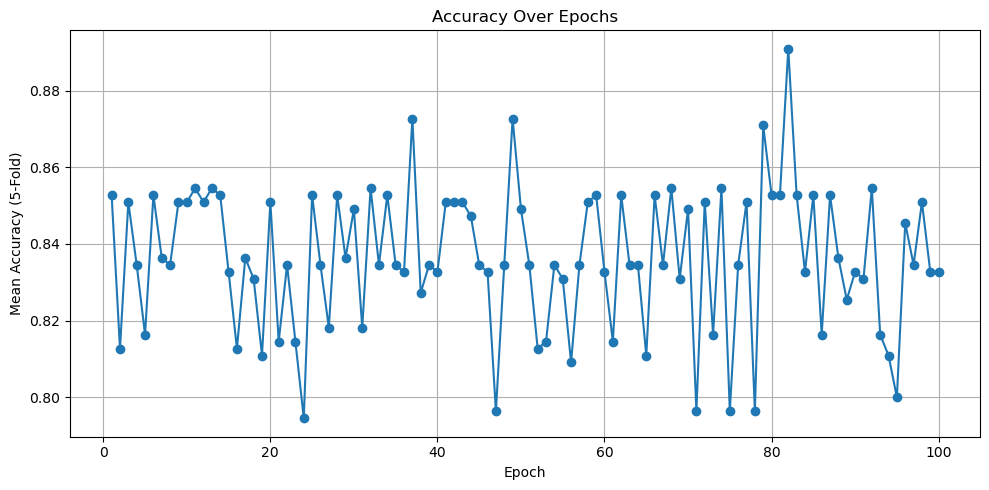

In [5]:
csv_dir = r"F:/Random Forest Model 2020/Training_CSV"
csv_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith(".csv")]

image_path = r"F:/Random Forest Model 2020/Reproject/S2_SR_HARMONIZED_BANDS_INDICES_4326.tif"
classified_output_dir = r"F:/Random Forest Model 2020/Classified_Output"
model_dir = r"F:/Random Forest Model 2020/RF_Model"
result_dir = r"F:/Random Forest Model 2020/Results"

os.makedirs(classified_output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

classified_output = os.path.join(classified_output_dir, "Sentinel2_With_Indices_20240217_Classified.tif")
model_path = os.path.join(model_dir, "Best_RandomForest_Model.pkl")

dfs = [pd.read_csv(f) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)
X = df.filter(like="Band")
y = df["Class_Value"]


epochs = 100
best_score = 0.0
best_model = None
accuracy_per_epoch = []

for epoch in range(epochs):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=epoch)
    fold_accuracies = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = RandomForestClassifier(n_estimators=300, random_state=epoch)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        fold_accuracies.append(acc)

        if acc > best_score:
            best_score = acc
            best_model = model
            joblib.dump(best_model, model_path)
            print(f"✅ Epoch {epoch+1}: Best model updated with accuracy: {acc:.4f}")

    accuracy_per_epoch.append(np.mean(fold_accuracies))

y_final_pred = best_model.predict(X_test)
print("\n🎯 Best Accuracy Achieved:", best_score)
print("📊 Classification Report:\n", classification_report(y_test, y_final_pred))

cm = confusion_matrix(y_test, y_final_pred)
labels = sorted(y.unique())

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(result_dir, "confusion_matrix.png"))
plt.show()

cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in labels], columns=[f"Pred_{i}" for i in labels])
cm_df.to_csv(os.path.join(result_dir, "confusion_matrix.csv"), index=True)

pd.DataFrame({
    "Epoch": list(range(1, epochs+1)),
    "Accuracy": accuracy_per_epoch
}).to_csv(os.path.join(result_dir, "accuracy_log.csv"), index=False)

with rasterio.open(image_path) as src:
    raster_data = src.read()
    meta = src.meta.copy()

n_bands, height, width = raster_data.shape
reshaped_data = raster_data.reshape(n_bands, -1).T
classified = best_model.predict(reshaped_data).reshape(height, width)

# Save classified output
meta.update(dtype='float32', count=1, nodata=np.nan)
out_path = classified_output.replace(".tif", "_float32.tif")
with rasterio.open(out_path, "w", **meta) as dst:
    dst.write(classified.astype(np.float32), 1)

print(f"✅ Final classified image saved to: {out_path}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), accuracy_per_epoch, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Mean Accuracy (5-Fold)")
plt.title("Accuracy Over Epochs")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, "accuracy_plot.png"), dpi=150)
plt.show()